In [17]:
from __future__ import print_function, division

import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
import torch.utils.data as data
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.cuda.empty_cache()


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((512,512)),
        transforms.ToTensor(),
        transforms.RandomRotation(10),
        transforms.RandomVerticalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((512,512)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "/content/drive/MyDrive/RA/"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'test':
              test_accuracy.append(epoch_acc)
              test_loss.append(epoch_loss)
            else:
              train_accuracy.append(epoch_acc)
              train_loss.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if epoch_acc > best_acc:
                model_name = f'CNS_{int(epoch+6)}_tuning_final.pth'
                path = f"/content/drive/MyDrive/RA/{model_name}" 
                torch.save(model.state_dict(), path)
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accuracy, train_loss, test_accuracy, test_loss

In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    # fig = plt.figure()
    correct = 0
    total = 0
    actual = []
    predicted_list = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            for i in range(len(predicted)):
              actual.append(labels[i].view(-1).detach().cpu().numpy())
              predicted_list.append(predicted[i].view(-1).detach().cpu().numpy())
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    return actual,predicted_list

In [14]:
# model_path = "/content/drive/MyDrive/RA/CNS_7783_tuning_final.pth"
# model_conv.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [52]:
model_conv,accuracy_list,train_loss,test_accuracy,test_loss = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=4)

In [53]:
actual,predicted_list = visualize_model(model_conv)

In [26]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

In [36]:
df = pd.DataFrame(accuracy_list,columns=['Accuracy'])
df['epochs'] = np.arange(1,len(accuracy_list)+1).astype('int')
df['train loss'] = train_loss

Text(0.5, 1.0, 'Loss')

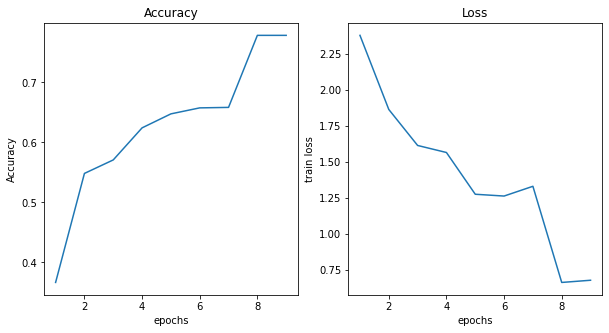

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
# plt.figure(figsize=(10,10))
# fig.suptitle('')
sns.lineplot(x='epochs',y='Accuracy',data=df,ax=ax1)
ax1.set_title('Accuracy')
sns.lineplot(x='epochs',y='train loss',data=df,ax=ax2)
ax2.set_title('Loss')

In [ ]:
# correct = 0
# total = 0
# actual = []
# predicted_list = []
# with torch.no_grad():
#     for _,(image,label) in enumerate(test_iter_loader):
#         images = image.to(device)
#         labels = label.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         for i in range(len(predicted)):
#             actual.append(labels[i].view(-1).detach().cpu().numpy())
#             predicted_list.append(predicted[i].view(-1).detach().cpu().numpy())
# #         actual.append(labels)
# #         predicted_list.append(predicted)
#         print(labels,predicted)
#         correct += (predicted == labels).sum().item()
# # 
# print('Accuracy of the network on the test images: %d %%' % (
#     100 * correct / total))

In [32]:
arr = classification_report(np.array(actual), np.array(predicted_list),target_names=class_names)

In [33]:
print(arr)

                 precision    recall  f1-score   support

          colon       0.84      0.62      0.71        50
  endometrium_1       0.51      0.84      0.64        50
  endometrium_2       0.80      0.56      0.66        50
         kidney       0.97      0.72      0.83        50
          liver       0.77      0.94      0.85        50
           lung       0.80      0.94      0.86        50
     lymph_node       0.44      0.82      0.57        50
       pancreas       1.00      0.52      0.68        50
         skin_1       0.68      0.68      0.68        50
         skin_2       0.48      0.90      0.63        50
small_intestine       0.88      0.44      0.59        50
         spleen       1.00      0.02      0.04        50

       accuracy                           0.67       600
      macro avg       0.76      0.67      0.64       600
   weighted avg       0.76      0.67      0.64       600



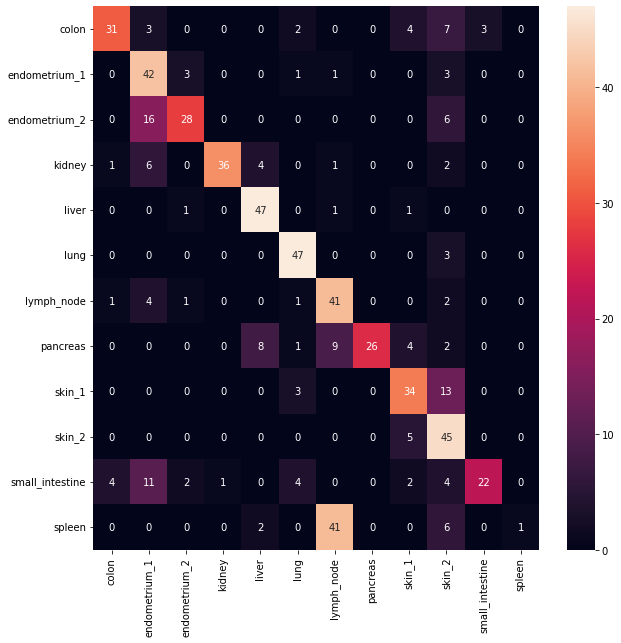

In [34]:
confusion_matrix = confusion_matrix(np.array(actual), np.array(predicted_list))
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(confusion_matrix),annot=True,xticklabels=class_names,yticklabels=class_names)

In [ ]:
# model_name = f'CNS_final_tuning.pth'
# path = f"/content/drive/MyDrive/RA/{model_name}" 
# torch.save(model_conv.state_dict(), path)